# Create synthetic import/export costs based on EPEX prices

In [1]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [2]:
start_time = pd.Timestamp('2020-01-01 00:00:00+00:00')
end_time = pd.Timestamp('2020-12-31 23:00:00+00:00')

In [4]:
df = pd.read_csv('temp_data/cleaned_energy_prices.csv' , parse_dates=['timestamp'])

# rename column Day-ahead Price (EUR/MWh)_hourly to price
df.rename(columns={'Day-ahead Price (EUR/MWh)_hourly': 'price'}, inplace=True)

df['price'] = df['price'] / 1000 # Convert price from EUR/MWh to EUR/kWh
df = df[(df['timestamp'] >= start_time) & (df['timestamp'] <= end_time)].copy()

<Axes: title={'center': 'Filtered EPEX Prices'}, xlabel='Timestamp', ylabel='Price (EUR/kWh)'>

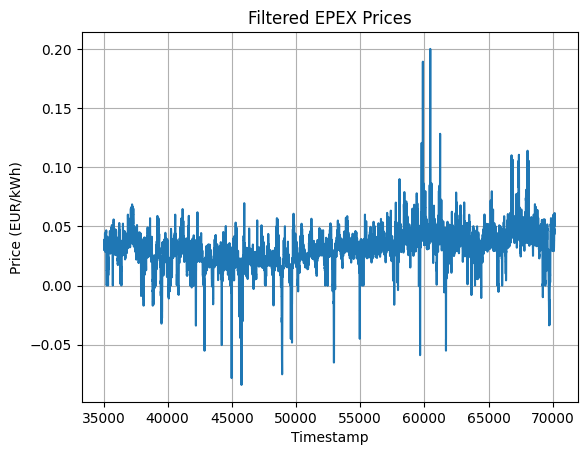

In [5]:
df['price'].plot(grid=True, title='Filtered EPEX Prices', ylabel='Price (EUR/kWh)', xlabel='Timestamp')

In [6]:
def get_import_prices(row, hour_p_start=16, hour_p_end=18, P_pence=13.0, D=2.1, VAT=1.19, tz='Europe/Berlin'):

    # P is in pence/kWh => Tranform it to €/kWh
    # For year 2020, 1 pence circa equals 0.0115 EUR
    P_euro = P_pence * 0.0115 # €/kWh

    #h = row['timestamp'].hour # this is in utc


    # transform the row to the local time zone
    row['timestamp'] = row['timestamp'].tz_convert(tz)

    # get the hour in the local time zone
    h = row['timestamp'].hour

    # retransform the row to utc
    row['timestamp'] = row['timestamp'].tz_convert('UTC')



    if hour_p_start <= h <= hour_p_end:
        P_now = P_euro
    else:
        P_now = 0

    # German Stromsteuer?
    P_now += 0.0205 # €/kWh

    return (D * row['price'] + P_now) * VAT


def get_export_prices(row, hour_p_start=16, hour_p_end=18, D=0.95, P_pence1=1.09, P_pence2=7.04, tz='Europe/Berlin'):

    # transform the row to the local time zone
    row['timestamp'] = row['timestamp'].tz_convert(tz)

    # get the hour in the local time zone
    h = row['timestamp'].hour

    # retransform the row to utc
    row['timestamp'] = row['timestamp'].tz_convert('UTC')

    # P is in pence/kWh => Tranform it to €/kWh
    # For year 2020, 1 pence circa equals 0.0115 EUR
    P_euro1 = P_pence1 * 0.0115  # €/kWh
    P_euro2 = P_pence2 * 0.0115  # €/kWh

    if hour_p_start <= h <= hour_p_end:
        P_now = P_euro1 +P_euro2
    else:
        P_now = P_euro1

    return max(D * row['price'] + P_now, 0)  # Ensure that export prices are not negative

In [ ]:
df_estimation = df.copy()
df_estimation['import_price'] = df_estimation.apply(get_import_prices, axis=1)
df_estimation['export_price'] = df_estimation.apply(get_export_prices, axis=1)
df_estimation.drop(columns=['price'], inplace=True)
df_estimation.set_index('timestamp', inplace=True)

# round the prices to 4 decimal places
df_estimation['import_price'] = df_estimation['import_price'].round(4)
df_estimation['export_price'] = df_estimation['export_price'].round(4)

In [8]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_estimation.index,y=df_estimation['import_price'],mode='lines',name='Import price'))
fig.add_trace(go.Scatter(x=df_estimation.index,y=df_estimation['export_price'],mode='lines',name='Export price'))

fig.update_layout(
    title='EPEX Import and Export Prices',
    xaxis_title='Timestamp',
    yaxis_title='Price (€/kWh)',
    hovermode='x unified',   # one hover box for both series
    template='plotly_white'
)
fig.show()

In [9]:
df_estimation.to_csv(f'electricity_price_estimation.csv')